# Problem Statement
Detecting cheating behaviors during examinations from images or videos to support proctors in monitoring and ensuring the integrity of the test. 
This task requires a computer vision model capable of accurate detection of actions such as copying from others or unauthorized discussion, under challenges such as student occlusion, varying camera angles, and subtle movements.

# Dataset overview

The study utilizes the "Exam Cheating" dataset from Roboflow Universe, comprising 241 images at a 640x640 resolution. Although the dataset includes multiple object types, our focus is exclusively on detecting "cheating students." Given the limited sample size, data augmentation is a critical step. The dataset already contains some pre-processed samples using Mosaic augmentation to enhance diversity.


Link dataset: https://universe.roboflow.com/kattal/exam-cheating/dataset/1


The dataset will be divided to 3 parts: 
* 210 images for training set
* 20 images for validation set
* 11 images for test set

# Installing and importing necessary libraries

In [1]:
!pip install ultralytics
!pip install roboflow
!pip install "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 423.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.7 MB/s eta 0:00:00
  At

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp
import os, json, cv2, yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import yaml
import os
import random
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO, RTDETR
import glob
from IPython.display import Image, display
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Explore data

#### Some example of the training data

We are going to show **5** example images of our dataset, consisting of images. The dataset consists of two classes: Student that isn't cheating, and student is.

Đường dẫn tuyệt đối đến thư mục ảnh train: /kaggle/input/exam-cheating/train/images

Hiển thị 5 ảnh ngẫu nhiên từ tập train...


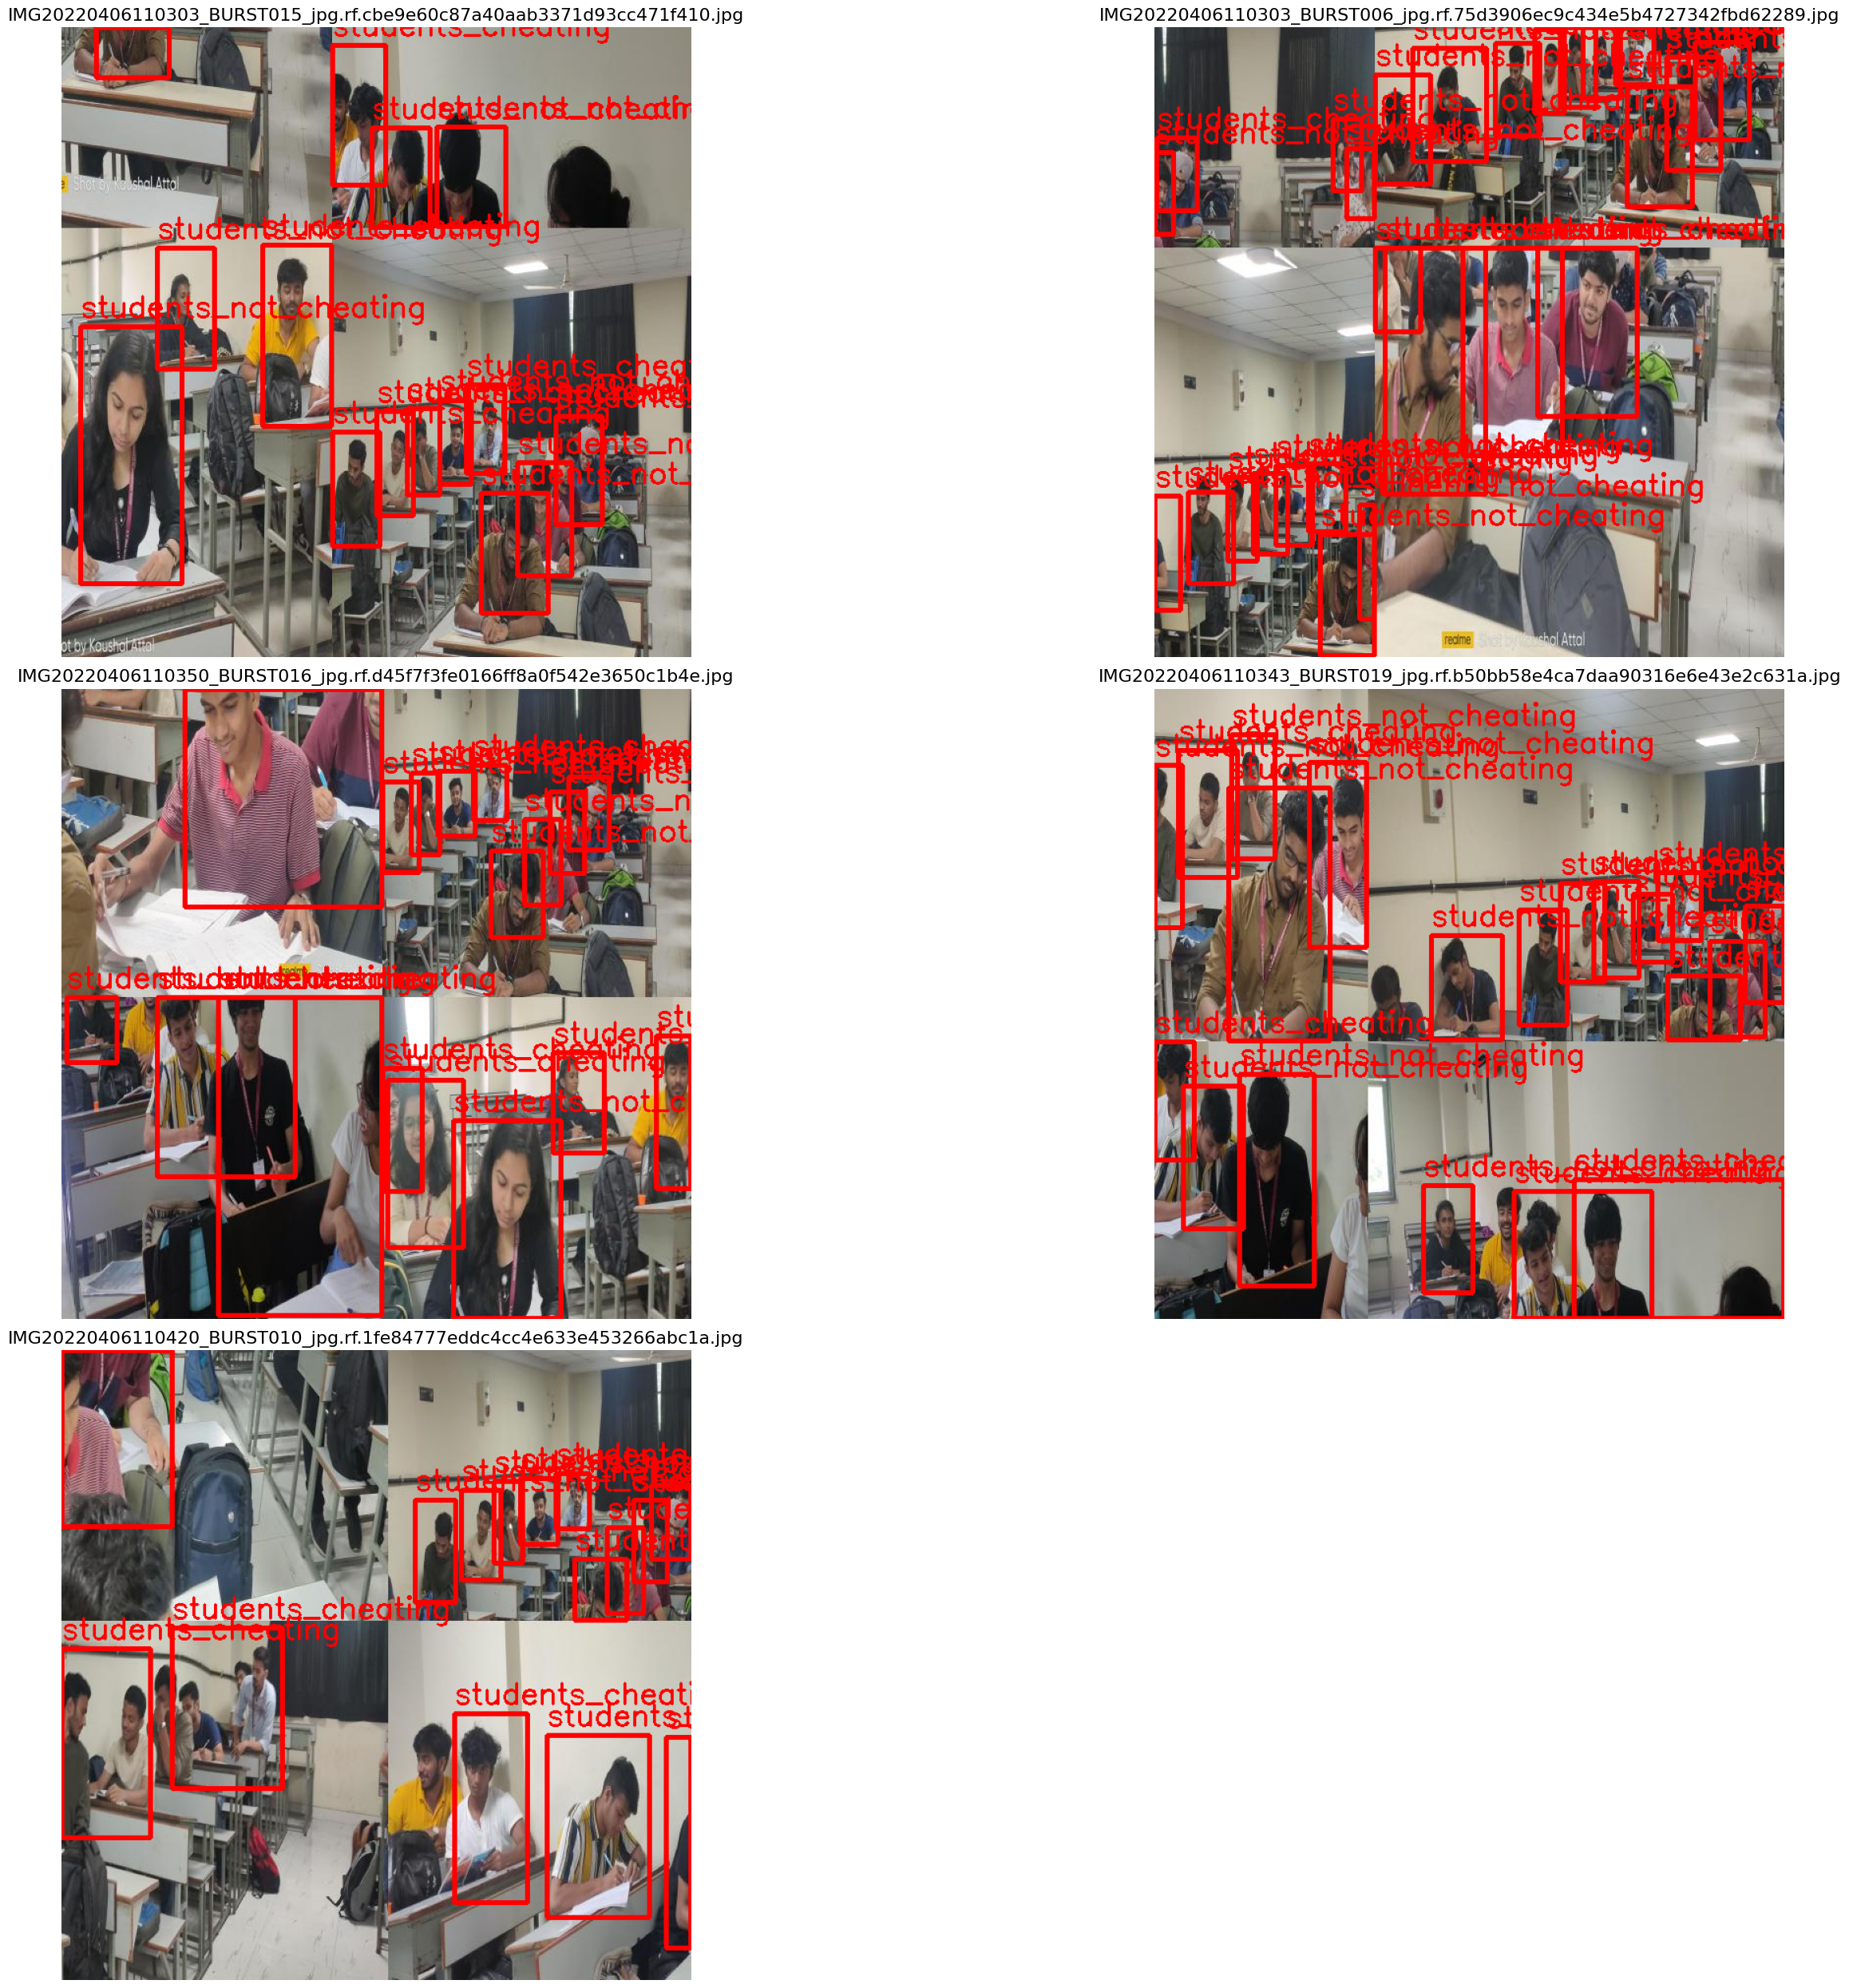

In [ ]:
# --- Cấu hình ---
DATA_YAML_PATH = '/kaggle/input/exam-cheating/data.yaml'
NUM_IMAGES_TO_SHOW = 5

# --- Đọc file data.yaml để lấy thông tin ---
with open(DATA_YAML_PATH, 'r') as f:
    data_config = yaml.safe_load(f)

# Lấy thư mục gốc của file data.yaml
data_yaml_dir = os.path.dirname(DATA_YAML_PATH)

# Lấy đường dẫn tương đối tới thư mục train và danh sách tên các lớp
relative_train_path = data_config['train']
class_names = data_config['names']

# Tạo đường dẫn tuyệt đối tới thư mục train images
train_img_dir = os.path.abspath(os.path.join(data_yaml_dir, "train/images"))
print(f"Đường dẫn tuyệt đối đến thư mục ảnh train: {train_img_dir}")

# --- Lấy danh sách ảnh và chọn ngẫu nhiên 5 ảnh ---
all_train_images = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(all_train_images, min(NUM_IMAGES_TO_SHOW, len(all_train_images)))

print(f"\nHiển thị {len(random_images)} ảnh ngẫu nhiên từ tập train...")

# --- Vẽ và hiển thị ảnh ---
plt.figure(figsize=(30, 25))

for i, img_name in enumerate(random_images):
    img_path = os.path.join(train_img_dir, img_name)
    label_path = os.path.join(train_img_dir.replace('images', 'labels'), os.path.splitext(img_name)[0] + '.txt')

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)
                class_id = int(class_id)

                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)

                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
                class_name = class_names[class_id]
                cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


    plt.subplot(3, 2, i + 1)
    plt.imshow(image)
    plt.title(img_name, fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Ultralytics model (YOLO and DETR) training function and parameters

In [ ]:
def train_yolo_family_model(
    model,
    data_dir: str,
    batch_size: int = 8,
    imgsz: int = 640,
    project_name: str = "",
    phase1_kwargs: dict = {},
    phase2_kwargs: dict = {}
):
    phase1_train = model.train(
        data=data_dir,
        project=project_name,
        batch=batch_size,
        imgsz=imgsz,
        name="phase1_warmup",
        **phase1_kwargs,
    )

    model_type = "yolo" if isinstance(model, YOLO) else "detr"

    PHASE_1_MODEL_PATH = f'/kaggle/working/{project_name}/phase1_warmup/weights/best.pt'

    if model_type == "yolo":
        phase2_model = YOLO(PHASE_1_MODEL_PATH)
    elif model_type == "detr":
        phase2_model = RTDETR(PHASE_1_MODEL_PATH)

    phase2_train = phase2_model.train(
        data=data_dir,
        batch=batch_size,
        imgsz=imgsz,
        project=project_name,
        name="phase2_main",
        **phase2_kwargs,
    )

    PHASE_2_MODEL_PATH = f'/kaggle/working/{project_name}/phase2_main/weights/best.pt'

    # Reload
    if model_type == "yolo":
        final_model = YOLO(PHASE_2_MODEL_PATH)
    elif model_type == "detr":
        final_model = RTDETR(PHASE_2_MODEL_PATH)

    return final_model

def evaluate_model(
    model,
    data_dir: str = DATA_YAML_PATH,
    project_name: str = "",
    bounding_box_threshold: float = 0.4,
    test_images_to_show: int = 5
):
    # Inference
    with open(data_dir, 'r') as f:
        data_config = yaml.safe_load(f)

    data_yaml_dir = os.path.dirname(data_dir)
    relative_test_path = data_config['test']
    test_img_dir = os.path.abspath(os.path.join(data_yaml_dir, "test/images"))

    test_image_paths = glob.glob(os.path.join(test_img_dir, '*.jpg')) # Hoặc .png, .jpeg
    random_test_images = random.sample(test_image_paths, min(test_images_to_show, len(test_image_paths)))

    print(f"\nThực hiện dự đoán trên {len(random_test_images)} ảnh ngẫu nhiên trong tập test...")

    results = model.predict(source=random_test_images, conf=bounding_box_threshold, save=True)


    print("\n--- Kết quả dự đoán ---")
    for i, result in enumerate(results):
        img_path = result.path
        saved_img_path = os.path.join(result.save_dir, os.path.basename(result.path))
        display(Image(filename=saved_img_path))

    # Metric evaluation
    model_type = "yolo" if isinstance(model, YOLO) else "detr"
    metrics = model.val(data=data_dir,
                    split='test',
                    imgsz=640,
                    batch=8,
                    project=project_name,
                    name=f'test_evaluation_{model_type}')

    print("\n--- Kết quả đánh giá (Metrics) ---")
    print(f"Precision(B): {metrics.box.p[0]:.4f}")
    print(f"Recall(B): {metrics.box.r[0]:.4f}")
    print(f"mAP50(B): {metrics.box.map50:.4f}")
    print(f"mAP50-95(B): {metrics.box.map:.4f}")
    print(f"Kết quả và các biểu đồ chi tiết được lưu tại: {metrics.save_dir}")


#  Training Hyperparameters and Data Augmentation Settings


The training method consists of two phases: Warm-up phase (Phase 1) and Main training phase (Phase 2).
In each phase, different augmentations techniques are used. Phase 1 has significantly less augmentations compared to phase 2.

Each parameter in the dictionary is vital for training, which means:


a) Training-related parameters
- lr0: Initial learning rate
- lrf: Final learning rate multiplier (cosine decay). 5e-3 means the learning rate will gradually decay back to 0.005x of the initial learning rate by the end of training
- warmup_epochs: The number of epoch for the learning-rate warm-up. For the first n epochs, the learning rate will gradually increase from a very small number, to lr0
- patience: Early stopping mechanism. The training will stop if validation metric has not improved for the last X epochs.


b) Data augmentations parameter
- mosaic: Mosaic blending probability. Combines 4 images into one large composite.
- mixup: Blends 2 images and their label proportionally.
- copy_paste: Randomly pastes objects from one image onto another.
- degrees: Maximum angle to randomly rotates image. 5 means the image will be rotated at most 5 or -5 degrees.
- translate: Fractional shift of image position (as a ratio of image size).
- scale: Controls zoom-in/out. For example: **0.05** means at most there will be $\pm5\%$ re-sizing.
- shear: Controls the tilting factor of the image.
- fliplr: Probability of horizontal flip. **0.1** means that there will be on average 10% of the images flipped left-right
- flipud: Probability of vertical flip. **0.1** means that on average, there will be 10% of the images flipped upside-down
- perspective: Controls the strength of perspective (3D) transformation applied during data augmentation. Imagine viewing from a tilted camera.

In [ ]:
phase1_params = {
    "lr0": 1e-4,
    "lrf": 5e-3,            # cosine decay end LR
    "warmup_epochs": 3,     # smooth ramp-up
    "mosaic": 0.1,          # very mild blending
    "mixup": 0.0,
    "copy_paste": 0.0,      # disable copy-paste
    "degrees": 0,
    "translate": 0.075,     # light translation
    "scale": 0.05,
    "shear": 0.0,
    "fliplr": 0.1,
    "flipud": 0.0,

    "patience": 8,
}

phase2_params = {
    "lr0": 0.0025,
    "lrf": 0.01,
    "momentum": 0.937,
    "weight_decay": 0.0005,
    "degrees": 5,
    "translate": 0.1,
    "scale": 0.1,
    "perspective": 0.0,  # usually unnecessary
    "flipud": 0.0,       # avoid if objects have orientation
    "fliplr": 0.5,
    "mosaic": 0.9,
    "shear": 5,
    "copy_paste": 0.1,
    "mixup": 0.0,
    "patience": 15,
}

# Evaluation metrics

We will be using mAP50 and mAP50-95 as our metric of choice for assessing the performance of models
- mAP50: Average precision at IoU = 0.5 (lenient correctness)
- mAP50-95: Mean of average precision over IoUs from 0.5 → 0.95 (stricter, COCO standard)

# YOLO training

In [ ]:
yolo_model = YOLO('yolo11l.pt')
trained_yolo = train_yolo_family_model(
    model=yolo_model,
    data_dir=DATA_YAML_PATH,
    project_name='yolo_cheating_detection',
    phase1_kwargs=phase1_params,
    phase2_kwargs=phase2_params
)

Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/exam-cheating/data.yaml, degrees=0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.1, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=0.1, multi_scale=False, name=phase1_warmup, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, pl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         20         94      0.708      0.787      0.823      0.664
     students_cheating         19         45       0.71      0.778      0.837      0.654
 students_not_cheating         14         49      0.706      0.796      0.809      0.673
Speed: 0.2ms preprocess, 17.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/yolo_cheating_detection/phase1_warmup
Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/exam-cheating/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscri

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         20         94      0.802      0.756      0.863      0.697
     students_cheating         19         45      0.868      0.778      0.887      0.712
 students_not_cheating         14         49      0.736      0.735      0.838      0.683
Speed: 0.8ms preprocess, 16.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolo_cheating_detection/phase2_main


# YOLO Evaluation


Thực hiện dự đoán trên 5 ảnh ngẫu nhiên trong tập test...

0: 640x640 4 students_cheatings, 31.4ms
1: 640x640 11 students_not_cheatings, 31.4ms
2: 640x640 1 students_cheating, 3 students_not_cheatings, 31.4ms
3: 640x640 2 students_cheatings, 3 students_not_cheatings, 31.4ms
4: 640x640 3 students_cheatings, 3 students_not_cheatings, 31.4ms
Speed: 1.3ms preprocess, 31.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/predict

--- Kết quả dự đoán ---


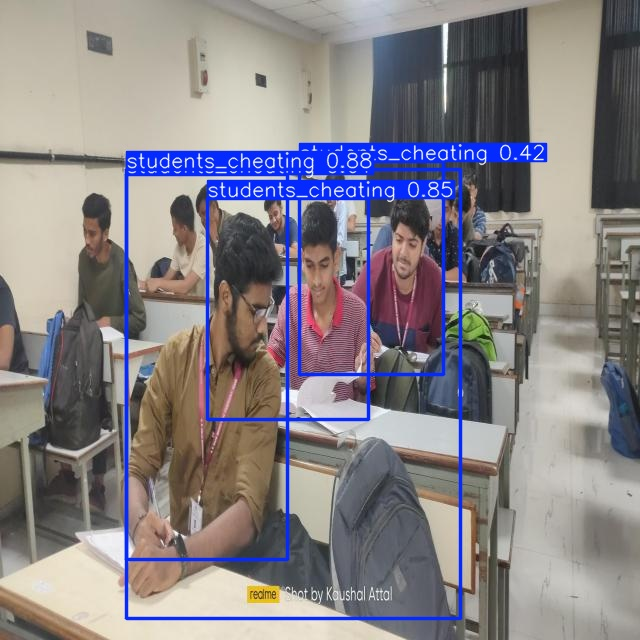

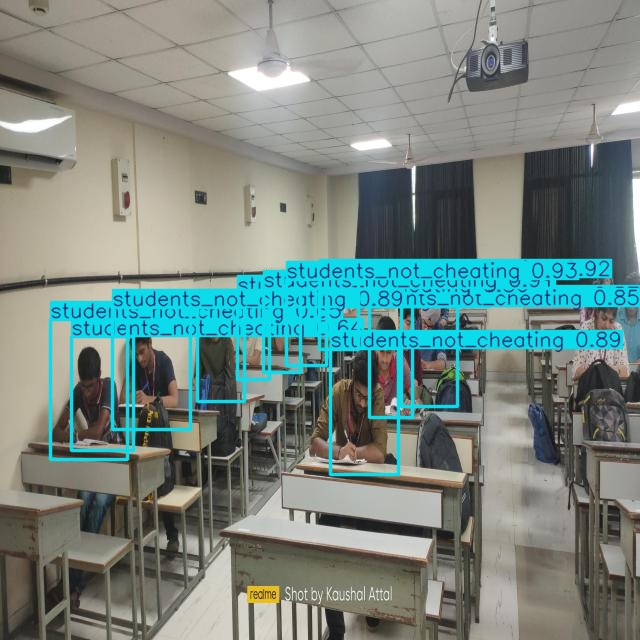

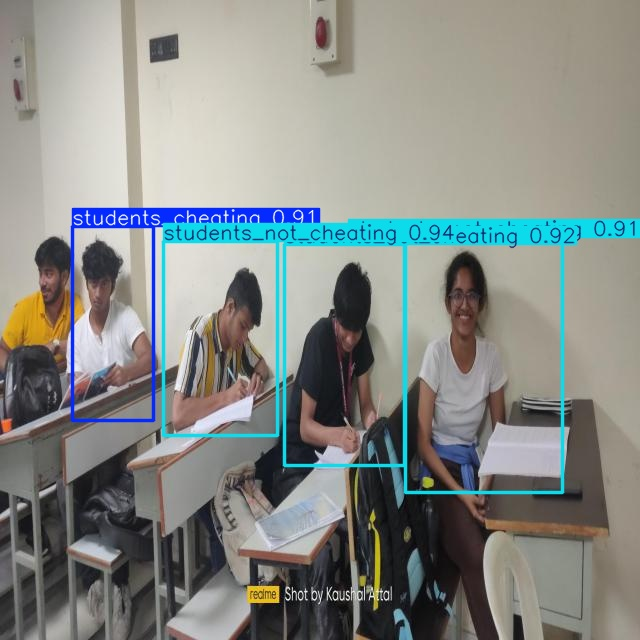

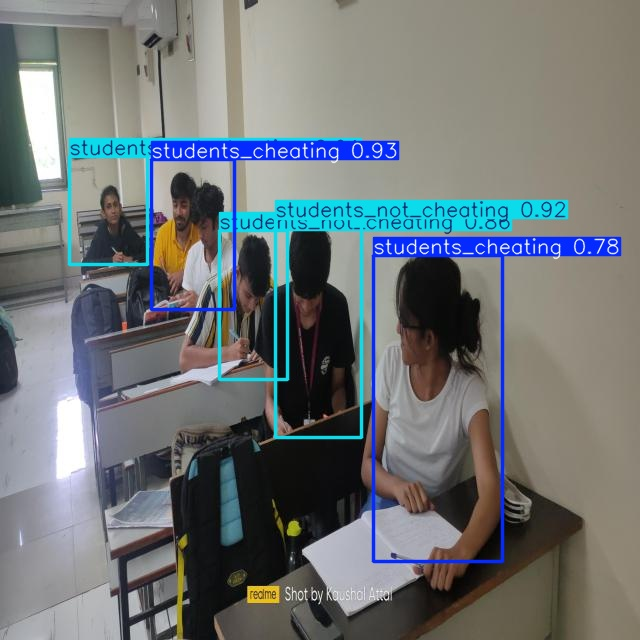

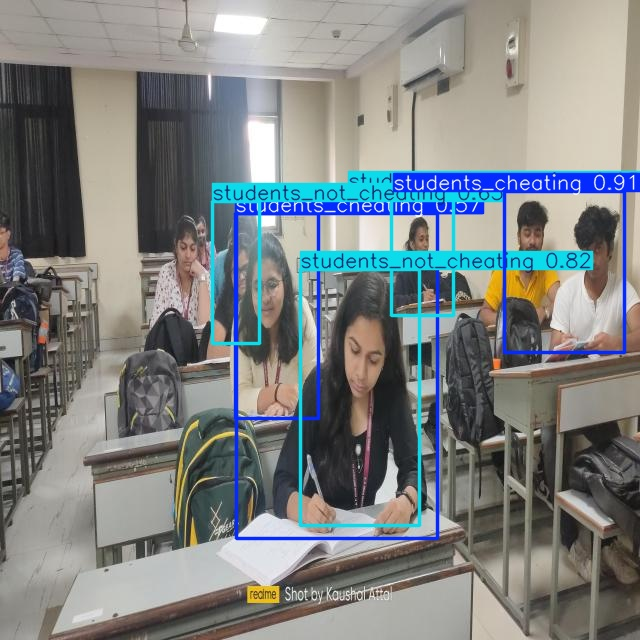

Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 32.9±21.0 MB/s, size: 53.9 KB)
val: Scanning /kaggle/input/exam-cheating/test/labels... 11 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 11/11 223.4it/s 0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/exam-cheating/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.0it/s 1.0s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         11         70      0.814      0.922      0.903      0.674
     students_cheating          6         14      0.769      0.952      0.871      0.578
 students_not_cheating          9         56      0.858      0.893      0.934       0.77
Speed: 5.6ms preprocess, 71.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolo_cheating_detection/test_evaluation_yolo

--- Kết quả đánh giá (Metrics) ---
Precision(B): 0.7689
Recall(B): 0.9517
mAP50(B): 0.9029
mAP50-95(B): 0.6742
Kết quả và các biểu đồ chi tiết được lưu tại: /kaggle/working/yolo_cheating_detection/test_evaluation_yolo


In [ ]:
evaluate_model(
    model=trained_yolo,
    project_name='yolo_cheating_detection'
)

# DETR Training 

In [ ]:
detr_model = RTDETR("rtdetr-l.pt")
trained_detr = train_yolo_family_model(
    model=detr_model,
    data_dir=DATA_YAML_PATH,
    project_name='detr_cheating_detection',
    phase1_kwargs=phase1_params,
    phase2_kwargs=phase2_params
)

Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/exam-cheating/data.yaml, degrees=0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.1, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=0.1, multi_scale=False, name=phase1_warmup, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, p

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/100      7.61G       2.17     0.4081      4.106         30        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 17.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.2it/s 0.5s
                   all         20         94      0.634      0.276      0.105     0.0337

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      2/100      7.45G      1.508     0.3883     0.9714        128        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/100      7.45G     0.8729     0.5725     0.4248         34        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.6it/s 0.4s
                   all         20         94      0.399      0.552      0.425       0.18

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      3/100       7.5G     0.6647     0.5606     0.2546        137        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/100      7.52G     0.6516     0.5625     0.2795         22        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.593      0.629      0.585      0.275

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      4/100      7.54G     0.7168     0.5597     0.3115        140        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/100      7.54G     0.6391     0.5546      0.277         42        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94       0.78      0.684      0.681      0.337

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      5/100      7.39G     0.6308      0.466     0.2522        138        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      5/100      7.41G      0.591     0.5262      0.245         48        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.654      0.688      0.633      0.323

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      6/100      7.46G     0.5997     0.5317     0.2601        153        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      6/100      7.48G     0.5784     0.5031     0.2411         40        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.642      0.682      0.648      0.368

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      7/100       7.4G     0.5693     0.4773     0.2396        148        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      7/100      7.42G     0.5365     0.4984     0.2172         35        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.752      0.716      0.699      0.403

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      8/100      7.28G     0.5741     0.4909     0.2225        122        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      8/100       7.3G     0.5222     0.4889     0.2066         25        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.736      0.775      0.741      0.438

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      9/100       7.3G     0.5233     0.4848     0.1971        130        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      9/100      7.39G     0.4992     0.4925     0.1936         27        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.717      0.805      0.763       0.46

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     10/100      7.37G     0.5088     0.4793     0.1987        138        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     10/100      7.38G     0.4891     0.4869      0.189         44        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.702      0.788      0.755       0.47

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     11/100      7.46G     0.4914      0.489     0.1945        143        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     11/100      7.48G     0.4404     0.4785     0.1734         22        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.711      0.805      0.774      0.464

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     12/100      7.34G     0.4157      0.423     0.1695        130        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     12/100      7.34G     0.4525     0.4651     0.1747         45        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.9it/s 0.4s
                   all         20         94      0.727      0.784      0.758      0.477

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     13/100      7.36G     0.4004     0.5316     0.1981         99        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     13/100      7.45G      0.425     0.4544      0.166         24        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.711      0.829      0.791        0.5

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     14/100       7.5G     0.4294     0.4887     0.1798        129        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     14/100      7.51G     0.4351     0.4506     0.1663         30        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.734       0.77      0.745      0.497

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     15/100      7.53G     0.5039     0.4809     0.1749        168        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     15/100      7.54G     0.3964     0.4443     0.1563         15        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.704      0.869      0.769      0.493

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     16/100      7.48G     0.3941     0.4706     0.1676        118        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     16/100       7.5G     0.3955     0.4423     0.1542         40        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.725      0.823      0.797      0.527

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     17/100       7.6G     0.3963     0.4377     0.1531        131        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     17/100      7.62G      0.369      0.429     0.1421         32        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.749      0.825      0.774      0.523

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     18/100      7.09G     0.3933     0.4266     0.1232        183        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     18/100      7.16G     0.3719     0.4212     0.1455         18        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94       0.65      0.765      0.751      0.485

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     19/100      7.16G     0.3312     0.4009     0.1449        149        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     19/100      7.33G     0.3657     0.4185     0.1446         30        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.693      0.854      0.782      0.525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     20/100      7.38G     0.4036     0.4791     0.1849        117        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     20/100      7.47G     0.3653     0.4161     0.1424         25        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.768      0.818      0.819      0.551

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     21/100      7.64G     0.3588     0.4414     0.1101        148        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     21/100      7.64G     0.3466     0.4057     0.1319         29        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.6it/s 0.4s
                   all         20         94       0.73      0.753      0.746      0.527

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     22/100      7.44G     0.3463     0.4103     0.1358        136        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     22/100      7.44G     0.3482     0.4088     0.1388         28        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94       0.67      0.781      0.732      0.511

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     23/100      7.51G     0.2168     0.3524    0.07367        140        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     23/100      7.52G       0.36     0.4139     0.1388         46        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.709      0.863      0.783      0.533

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     24/100      7.31G     0.3668     0.4205     0.1339        152        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     24/100      7.33G     0.3372     0.3956     0.1346         32        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.667      0.842      0.735      0.506

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     25/100      7.33G     0.3483     0.3768     0.1397        134        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     25/100      7.41G     0.3313     0.4017     0.1289         24        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94       0.69      0.822      0.733      0.538

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     26/100      7.54G     0.2853     0.3524    0.09518        147        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     26/100      7.55G     0.3277      0.385     0.1297         31        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.789      0.893      0.836      0.563

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     27/100      7.51G     0.2687     0.3668     0.1082        130        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     27/100      7.53G     0.3305     0.3835      0.127         36        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.694      0.814       0.75      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     28/100      7.51G     0.2957     0.3339     0.1337        101        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     28/100      7.51G     0.2956     0.3694     0.1171         31        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.744      0.888      0.819      0.587

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     29/100      7.39G      0.306     0.3414     0.1218        177        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     29/100      7.41G     0.2834      0.362     0.1103         38        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.748      0.799      0.817      0.596

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     30/100       7.5G     0.3854     0.3786     0.1502        177        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     30/100      7.52G     0.2906     0.3618     0.1102         51        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.713      0.852       0.82      0.596

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     31/100      7.49G      0.159     0.2993      0.064         99        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     31/100      7.51G     0.2816     0.3476     0.1102         27        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.753      0.831      0.807      0.566

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     32/100      7.35G     0.2886     0.3554     0.1113        129        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     32/100      7.38G     0.2822     0.3544     0.1075         34        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.765      0.815      0.769      0.561

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     33/100       7.3G      0.288     0.3581     0.1028        153        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     33/100      7.32G     0.2629     0.3336     0.1007         46        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94       0.74      0.817      0.763      0.592

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     34/100      7.32G     0.3208     0.3484     0.1275        164        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     34/100      7.41G      0.278     0.3443     0.1079         28        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.704       0.86      0.778      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     35/100       7.3G       0.35     0.3714     0.1664        117        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     35/100      7.32G     0.2554       0.33    0.09873         36        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.743      0.861      0.803      0.582

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     36/100      7.32G     0.2661     0.3132     0.1177        136        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     36/100      7.36G     0.2428     0.3143    0.09185         32        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.731      0.857      0.766      0.584

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     37/100      7.44G     0.2454      0.323     0.1154        125        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     37/100      7.44G     0.2433     0.3133     0.0957         39        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.739      0.813      0.774      0.567

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     38/100      7.52G     0.2438     0.3443    0.08855        131        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     38/100      7.52G     0.2616     0.3249     0.1051         34        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.754      0.789      0.782      0.572
EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

38 epochs completed in 0.194 hours.
Optimizer stripped from /kaggle/working/detr_cheating_detection/phase1_warmup/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/detr_cheating_detection/phase1_warmup/weights/best.pt, 66.2MB

Validating /kaggle/working/detr_cheating_detection/phase1_warmup/weights/best.pt...
Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         20         94      0.713      0.852      0.819      0.596
     students_cheating         19         45      0.733      0.867      0.841      0.624
 students_not_cheating         14         49      0.694      0.837      0.797      0.567
Speed: 0.2ms preprocess, 22.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/detr_cheating_detection/phase1_warmup
Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/exam-cheating/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscri

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/100      7.74G     0.4652     0.4642     0.1875         23        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 17.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.6it/s 0.4s
                   all         20         94      0.748      0.839      0.817      0.476

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      2/100      7.83G     0.3559      0.444      0.135        158        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/100      7.92G     0.4267     0.4559     0.1681         67        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.6it/s 0.4s
                   all         20         94      0.717      0.814      0.803      0.499

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      3/100      7.82G     0.4709       0.45     0.1872        171        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/100      7.92G     0.4391     0.4742     0.1762         43        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.762      0.849      0.825      0.507

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      4/100      7.83G     0.3384     0.4299     0.1156        190        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/100      7.87G     0.4242     0.4593     0.1673         57        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94       0.72      0.895      0.833      0.492

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      5/100      8.19G     0.4265     0.4478     0.1679        180        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      5/100      8.28G     0.4248     0.4624     0.1694         33        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.757      0.839      0.839      0.444

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      6/100      7.72G     0.4153     0.4653     0.1736        166        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      6/100      7.81G     0.4108     0.4673     0.1621         40        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.729      0.794      0.811      0.409

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      7/100      7.85G     0.4204     0.4946     0.1611        167        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      7/100      7.95G     0.4308     0.4741     0.1705         25        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.763      0.861      0.853      0.474

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      8/100      8.03G     0.4267     0.4504     0.1627        163        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      8/100      8.12G     0.4075     0.4573     0.1645         41        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.721      0.761      0.751      0.456

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      9/100      8.18G       0.39     0.4407     0.1632        165        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      9/100      8.27G     0.4106     0.4443     0.1657         37        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.739      0.794      0.774      0.437

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     10/100      7.87G     0.4173     0.4659     0.1608        173        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     10/100         8G     0.4072     0.4529     0.1622         33        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94       0.72      0.835      0.766      0.492

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     11/100       7.8G     0.3702     0.4464     0.1466        153        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     11/100      7.89G     0.4048     0.4546     0.1615         63        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.768      0.864      0.846      0.478

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     12/100      7.85G     0.3805     0.4278     0.1605        156        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     12/100       7.9G     0.3679     0.4338      0.147         49        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.729      0.849      0.807      0.475

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     13/100      7.98G     0.3942     0.4297     0.1571        155        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     13/100      8.07G     0.3814     0.4438     0.1529         35        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.765      0.758      0.726      0.447

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     14/100      7.84G     0.3814     0.4552      0.153        188        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     14/100      7.94G     0.3726     0.4384     0.1493         32        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.737      0.828      0.778      0.463

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     15/100      7.97G     0.4221     0.4311     0.1558        184        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     15/100      8.06G     0.3923     0.4439     0.1555         30        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.732       0.87        0.8      0.504

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     16/100         8G     0.4423     0.4821     0.1725        135        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     16/100      8.09G     0.3731     0.4456     0.1459         28        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.736      0.822      0.737      0.462

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     17/100      7.96G     0.4016     0.4217     0.1506        174        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     17/100      8.06G     0.3709     0.4342     0.1437         37        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.704      0.783      0.721       0.48

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     18/100      7.72G     0.3796     0.4121     0.1382        226        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     18/100      7.86G     0.3848     0.4303     0.1545         34        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.718      0.804      0.751       0.51

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     19/100      8.11G     0.3786     0.4314     0.1519        155        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     19/100       8.2G     0.3702     0.4373     0.1492         29        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.721      0.867      0.803      0.472

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     20/100      7.89G     0.3948     0.4433     0.1554        172        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     20/100      7.94G     0.3786     0.4354     0.1453         37        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.739      0.828      0.791      0.469

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     21/100      8.09G     0.4106     0.4713     0.1586        179        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     21/100      8.18G     0.3683     0.4349     0.1476         33        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.733      0.885      0.847      0.499

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     22/100      7.88G     0.4068     0.4915     0.1647        173        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     22/100      7.97G     0.3659     0.4373      0.143         32        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.731      0.882      0.809      0.507

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     23/100      8.02G     0.2979     0.4043    0.09941        160        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     23/100      8.12G     0.3572     0.4244     0.1441         32        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.746      0.791      0.789      0.547

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     24/100      7.89G     0.3414     0.3922      0.108        179        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     24/100      7.99G     0.3542     0.4163     0.1349         34        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94       0.69      0.915      0.825      0.523

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     25/100      7.92G     0.2961     0.3792     0.1142        160        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     25/100      8.02G      0.354     0.4182     0.1426         35        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.732       0.84       0.79      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     26/100      7.88G      0.351     0.3976     0.1421        137        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     26/100      8.02G     0.3369     0.4087     0.1326         21        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.744      0.795      0.752      0.466

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     27/100      7.88G      0.316      0.396       0.11        153        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     27/100      7.98G     0.3189     0.4027     0.1213         43        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.766      0.839      0.782       0.48

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     28/100      7.88G     0.3466     0.4298     0.1485        133        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     28/100      7.93G      0.318     0.3991     0.1253         51        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.5it/s 0.4s
                   all         20         94      0.751      0.845      0.767       0.47

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     29/100       7.8G     0.2902     0.3946      0.106        177        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     29/100       7.9G     0.3299     0.4008     0.1293         35        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.758      0.828      0.792      0.455

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     30/100      8.17G     0.2965     0.4125     0.0955        174        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     30/100      8.26G     0.3311     0.4118     0.1348         23        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94       0.69      0.874      0.801       0.49

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     31/100      8.14G     0.2474     0.3616    0.09619        128        640: 0% ──────────── 0/27  0.7s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     31/100      8.24G     0.3244     0.3971     0.1265         32        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.765      0.892      0.838      0.506

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     32/100      7.98G     0.3973       0.45     0.2057        130        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     32/100      8.08G     0.3291     0.4077     0.1317         47        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.745      0.855      0.779      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     33/100      7.98G     0.2656     0.3983    0.09829        151        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     33/100      8.07G     0.3196     0.3933     0.1232         50        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.764      0.858      0.825      0.509

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     34/100      7.85G     0.3351     0.4235      0.146        149        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     34/100      7.99G     0.3178     0.4013     0.1228         30        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.766      0.853      0.812        0.5

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     35/100      7.92G     0.2838     0.3976     0.1089        160        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     35/100      8.02G     0.3193     0.3953     0.1233         39        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.7it/s 0.4s
                   all         20         94      0.767      0.867      0.842      0.541

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     36/100      8.04G     0.2939     0.3721    0.09625        177        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     36/100      8.09G     0.3118     0.3823     0.1176         49        640: 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.758      0.845      0.789      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     37/100      7.83G     0.3285     0.3796     0.1283        195        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     37/100      7.92G     0.3138     0.3978     0.1207         34        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.793      0.891      0.856      0.495

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     38/100      7.84G     0.3113     0.3845     0.1146        160        640: 0% ──────────── 0/27  0.6s

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     38/100      7.94G     0.3265     0.3997     0.1293         58        640: 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.8it/s 0.4s
                   all         20         94      0.733      0.808      0.772      0.508
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

38 epochs completed in 0.194 hours.
Optimizer stripped from /kaggle/working/detr_cheating_detection/phase2_main/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/detr_cheating_detection/phase2_main/weights/best.pt, 66.2MB

Validating /kaggle/working/detr_cheating_detection/phase2_main/weights/best.pt...
Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         20         94      0.745      0.792      0.788      0.545
     students_cheating         19         45      0.767      0.733      0.806      0.548
 students_not_cheating         14         49      0.723      0.851      0.771      0.543
Speed: 0.2ms preprocess, 21.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/detr_cheating_detection/phase2_main


# DETR Evaluation


Thực hiện dự đoán trên 5 ảnh ngẫu nhiên trong tập test...

0: 640x640 3 students_cheatings, 1 students_not_cheating, 50.1ms
1: 640x640 12 students_not_cheatings, 50.1ms
2: 640x640 1 students_cheating, 3 students_not_cheatings, 50.1ms
3: 640x640 2 students_cheatings, 3 students_not_cheatings, 50.1ms
4: 640x640 4 students_cheatings, 2 students_not_cheatings, 50.1ms
Speed: 1.3ms preprocess, 50.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/predict2

--- Kết quả dự đoán ---


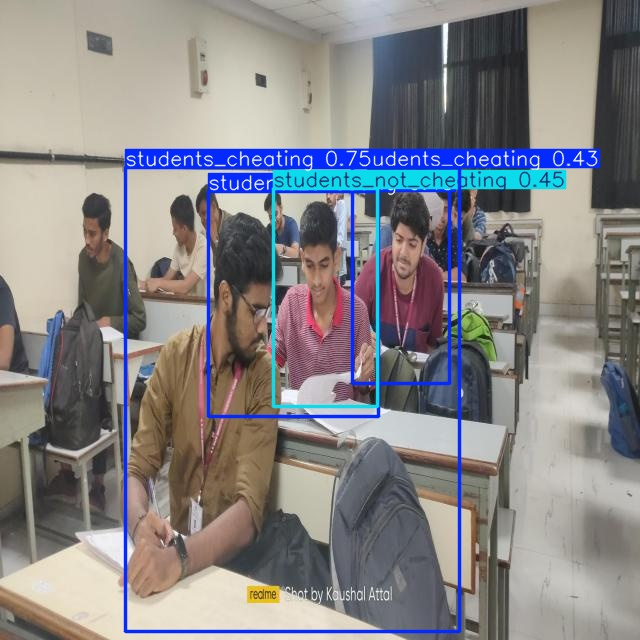

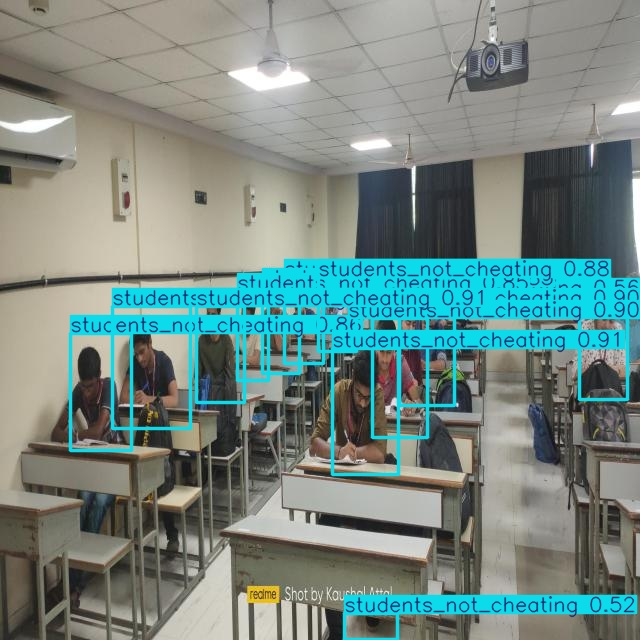

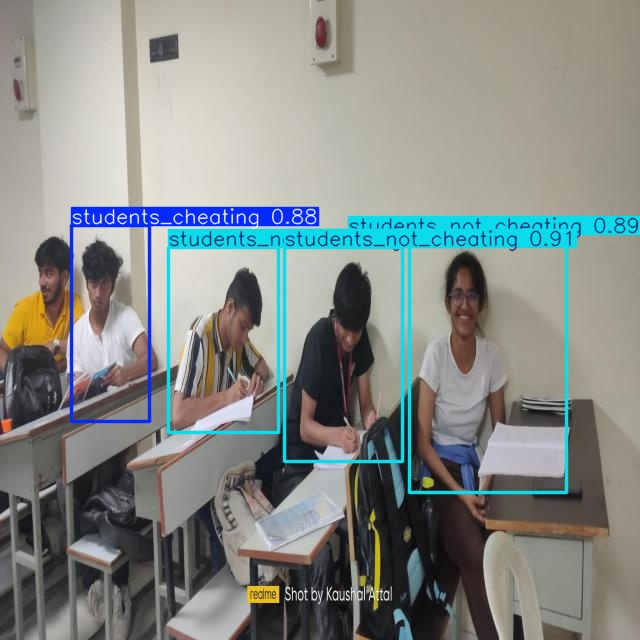

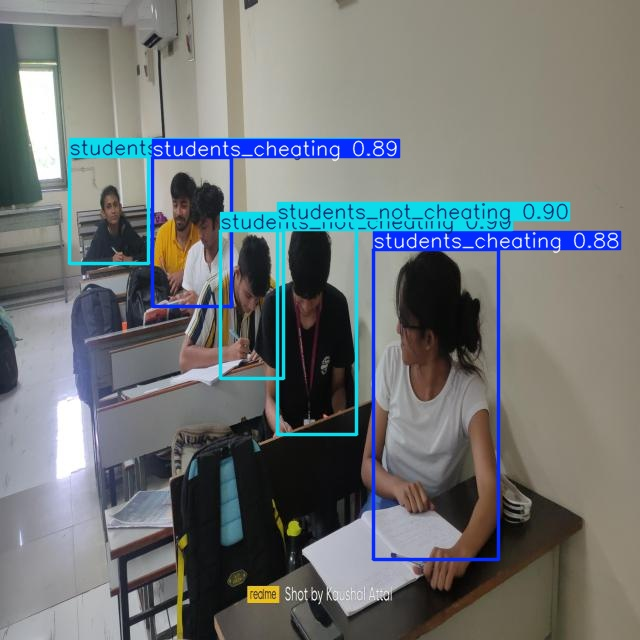

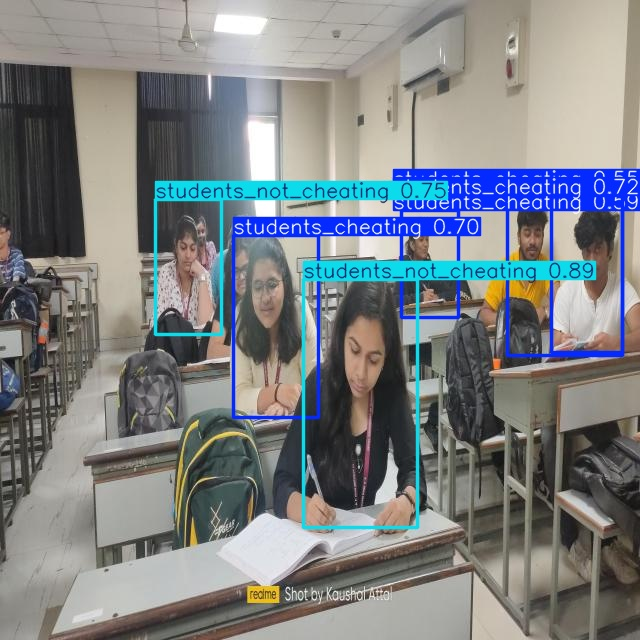

Ultralytics 8.3.222 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 1.1±1.4 ms, read: 48.1±8.4 MB/s, size: 53.9 KB)
val: Scanning /kaggle/input/exam-cheating/test/labels... 11 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 11/11 390.0it/s 0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/exam-cheating/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.1it/s 1.0s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         11         70      0.759      0.866      0.775      0.555
     students_cheating          6         14      0.636      0.786      0.666      0.491
 students_not_cheating          9         56      0.883      0.946      0.883      0.619
Speed: 4.9ms preprocess, 74.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /kaggle/working/detr_cheating_detection/test_evaluation_detr

--- Kết quả đánh giá (Metrics) ---
Precision(B): 0.6357
Recall(B): 0.7857
mAP50(B): 0.7745
mAP50-95(B): 0.5546
Kết quả và các biểu đồ chi tiết được lưu tại: /kaggle/working/detr_cheating_detection/test_evaluation_detr


In [ ]:
evaluate_model(
    model=trained_detr,
    project_name='detr_cheating_detection'
)

# Faster R-CNN

###  Data Format Conversion: YOLO → COCO


In [ ]:
def convert_yolo_to_coco(data_yaml_path, output_dir):
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    class_names = data_config['names']
    os.makedirs(os.path.join(output_dir, 'annotations'), exist_ok=True)
    data_yaml_dir = os.path.dirname(data_yaml_path)

    for split in ['train', 'valid', 'test']:
        actual_split_key = 'val' if split == 'valid' else split

        if actual_split_key not in data_config:
            continue

        img_dir = os.path.join(data_yaml_dir, split, 'images')
        label_dir = os.path.join(data_yaml_dir, split, 'labels')

        if not os.path.exists(img_dir):
            continue

        coco_output = {
            "info": {}, "licenses": [], "categories": [],
            "images": [], "annotations": []
        }

        for i, class_name in enumerate(class_names):
            coco_output["categories"].append({
                "id": i, "name": class_name, "supercategory": "object"
            })

        image_id_counter = 0
        annotation_id_counter = 0

        image_files = [f for f in os.listdir(img_dir)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in tqdm(image_files, desc=f"Converting {actual_split_key} set"):
            img_path = os.path.join(img_dir, img_name)
            try:
                image = cv2.imread(img_path)
                h, w, _ = image.shape
            except Exception as e:
                print(f"Không thể đọc ảnh: {img_path}. Lỗi: {e}")
                continue

            image_info = {
                "id": image_id_counter,
                "file_name": img_name,
                "width": w,
                "height": h
            }
            coco_output["images"].append(image_info)

            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        class_id, x_center, y_center, width, height = map(float, parts)

                        abs_w, abs_h = width * w, height * h
                        x_min = (x_center * w) - (abs_w / 2)
                        y_min = (y_center * h) - (abs_h / 2)

                        annotation_info = {
                            "id": annotation_id_counter,
                            "image_id": image_id_counter,
                            "category_id": int(class_id),
                            "bbox": [round(x, 2) for x in [x_min, y_min, abs_w, abs_h]],
                            "area": round(abs_w * abs_h, 2),
                            "iscrowd": 0,
                            "segmentation": []
                        }
                        coco_output["annotations"].append(annotation_info)
                        annotation_id_counter += 1

            image_id_counter += 1

        output_json_path = os.path.join(output_dir, f'annotations/{actual_split_key}.json')
        with open(output_json_path, 'w') as f:
            json.dump(coco_output, f, indent=4)

### Create Custom Dataset 

In [ ]:
class COCODataset(Dataset):
    def __init__(self, root, annotation_file, augmentations=None):
        self.root = root

        self.augmentations = augmentations
        self.to_tensor = T.ToTensor()

        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        print(f"Đã tải {len(self.ids)} ảnh từ {annotation_file}")

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = cv2.imread(os.path.join(self.root, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []

        for ann in anns:
            xmin, ymin, width, height = ann['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.augmentations is not None:
            img = self.augmentations(img)

        img = self.to_tensor(img)
        return img, target

    def __len__(self):
        return len(self.ids)

### Faster R-CNN Model Initialization


In [ ]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### Training and Evaluation Function for Faster-RCNN

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0

    with tqdm(data_loader, desc=f"Epoch {epoch}") as pbar:
        for images, targets in pbar:
            for idx, img in enumerate(images):
                if img.shape[0] != 3:
                    print(f"Warning: Image {idx} has {img.shape[0]} channels, expected 3")

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
            pbar.set_postfix({'loss': losses.item()})

    return total_loss / len(data_loader)


@torch.no_grad()
def evaluate(model, data_loader, device, coco_gt):
    model.eval()
    results = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for target, output in zip(targets, outputs):
            image_id = target['image_id'].item()
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box
                results.append({
                    'image_id': image_id,
                    'category_id': int(label),
                    'bbox': [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    'score': float(score)
                })

    if len(results) == 0:
        print("Không có detection nào được tạo ra!")
        return None

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats

### End-to-End Training and Evaluation Pipeline for Faster-RCNN


In [ ]:
def main():
    # Cấu hình
    DATA_YAML_PATH = '/kaggle/input/exam-cheating/data.yaml'
    OUTPUT_COCO_DIR = '/kaggle/working/coco_dataset/'
    OUTPUT_TRAINING_DIR = "/kaggle/working/output_faster_rcnn/"

    # Bước 1: Chuyển đổi dữ liệu
    convert_yolo_to_coco(DATA_YAML_PATH, OUTPUT_COCO_DIR)


    data_yaml_dir = os.path.dirname(DATA_YAML_PATH)
    with open(DATA_YAML_PATH, 'r') as f:
        data_config = yaml.safe_load(f)
        num_classes = len(data_config['names']) + 1  # +1 cho background

    # Setup device - Multi-GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Tạo datasets
    train_dataset = COCODataset(
        root=os.path.join(data_yaml_dir, 'train', 'images'),
        annotation_file=os.path.join(OUTPUT_COCO_DIR, 'annotations/train.json')
    )

    val_dataset = COCODataset(
        root=os.path.join(data_yaml_dir, 'valid', 'images'),
        annotation_file=os.path.join(OUTPUT_COCO_DIR, 'annotations/val.json')
    )

    test_dataset = COCODataset(
        root=os.path.join(data_yaml_dir, 'test', 'images'),
        annotation_file=os.path.join(OUTPUT_COCO_DIR, 'annotations/test.json')
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    # Tạo model
    model = get_model(num_classes)
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training
    num_epochs = 10
    os.makedirs(OUTPUT_TRAINING_DIR, exist_ok=True)

    for epoch in range(num_epochs):
        avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        lr_scheduler.step()
        print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")

        # Lưu checkpoint
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(),
                      os.path.join(OUTPUT_TRAINING_DIR, f'model_epoch_{epoch}.pth'))
        else:
            torch.save(model.state_dict(),
                      os.path.join(OUTPUT_TRAINING_DIR, f'model_epoch_{epoch}.pth'))

    # Lưu model cuối
    final_model_path = os.path.join(OUTPUT_TRAINING_DIR, 'model_final.pth')
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.state_dict(), final_model_path)
    else:
        torch.save(model.state_dict(), final_model_path)


    # Evaluation trên test set

    # Load COCO ground truth
    coco_gt = COCO(os.path.join(OUTPUT_COCO_DIR, 'annotations/test.json'))

    # Unwrap model nếu là DataParallel
    eval_model = model.module if isinstance(model, nn.DataParallel) else model

    stats = evaluate(eval_model, test_loader, device, coco_gt)

    if stats is not None:
        print("\n--- KẾT QUẢ FASTER R-CNN TRÊN TẬP TEST ---")
        print(f"AP (IoU=0.50:0.95): {stats[0]:.4f}")
        print(f"AP50 (IoU=0.50): {stats[1]:.4f}")
        print(f"AP75 (IoU=0.75): {stats[2]:.4f}")
        print(f"AR (max=100): {stats[8]:.4f}")


if __name__ == '__main__':
    main()

Converting test set: 100%|██████████| 11/11 [00:00<00:00, 160.49it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Đã tải 210 ảnh từ /kaggle/working/coco_dataset/annotations/train.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Đã tải 20 ảnh từ /kaggle/working/coco_dataset/annotations/val.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Đã tải 11 ảnh từ /kaggle/working/coco_dataset/annotations/test.json


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 219MB/s]
Epoch 0: 100%|██████████| 53/53 [00:47<00:00,  1.11it/s, loss=0.547]


Epoch 0: Average Loss = 1.1015


Epoch 1: 100%|██████████| 53/53 [00:45<00:00,  1.17it/s, loss=0.751]


Epoch 1: Average Loss = 0.7925


Epoch 2: 100%|██████████| 53/53 [00:46<00:00,  1.14it/s, loss=0.724]


Epoch 2: Average Loss = 0.6851


Epoch 3: 100%|██████████| 53/53 [00:45<00:00,  1.16it/s, loss=0.293]


Epoch 3: Average Loss = 0.5829


Epoch 4: 100%|██████████| 53/53 [00:46<00:00,  1.15it/s, loss=0.43]


Epoch 4: Average Loss = 0.5518


Epoch 5: 100%|██████████| 53/53 [00:46<00:00,  1.15it/s, loss=0.602]


Epoch 5: Average Loss = 0.5395


Epoch 6: 100%|██████████| 53/53 [00:46<00:00,  1.14it/s, loss=0.382]


Epoch 6: Average Loss = 0.5223


Epoch 7: 100%|██████████| 53/53 [00:46<00:00,  1.15it/s, loss=0.504]


Epoch 7: Average Loss = 0.5208


Epoch 8: 100%|██████████| 53/53 [00:46<00:00,  1.15it/s, loss=0.571]


Epoch 8: Average Loss = 0.5203


Epoch 9: 100%|██████████| 53/53 [00:46<00:00,  1.15it/s, loss=0.638]


Epoch 9: Average Loss = 0.5203
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.253
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

# Metric comparison

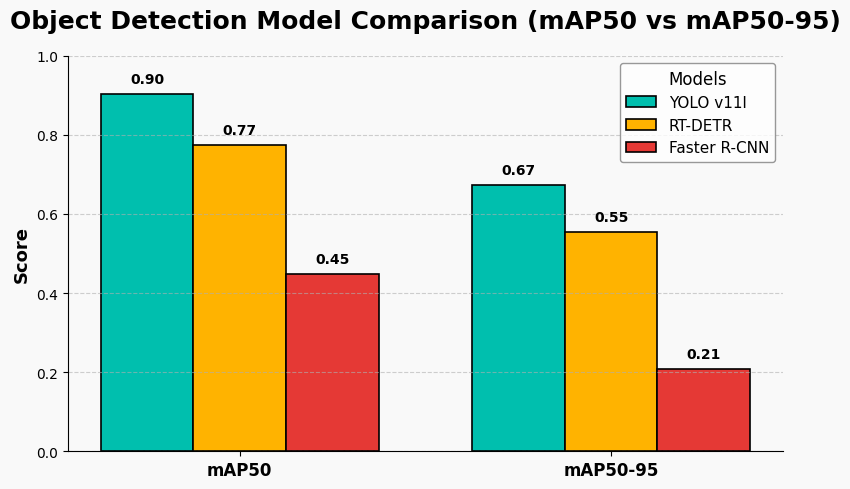

In [3]:
models = ['YOLO v11l', 'RT-DETR', 'Faster R-CNN']

# Metrics and values
metrics = ['mAP50', 'mAP50-95']
values = np.array([
    [0.9029, 0.6742],  # YOLO v11l
    [0.7745, 0.5546],  # RT-DETR
    [0.4495, 0.2092],  # Faster R-CNN
])

# Setup
x = np.arange(len(metrics))
width = 0.25
colors = ['#00BFAE', '#FFB300', '#E53935']  # teal, amber, red

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('#f9f9f9')
fig.patch.set_facecolor('#f9f9f9')

# Draw grouped bars
for i, (model, color) in enumerate(zip(models, colors)):
    ax.bar(
        x + (i - 1) * width,
        values[i],
        width,
        label=model,
        color=color,
        edgecolor='black',
        linewidth=1.2
    )

# Labels and layout
ax.set_title('Object Detection Model Comparison (mAP50 vs mAP50-95)', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Value annotations
for i in range(len(models)):
    for j in range(len(metrics)):
        height = values[i, j]
        ax.text(
            x[j] + (i - 1) * width,
            height + 0.02,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

# Legend
ax.legend(
    title='Models',
    title_fontsize=12,
    fontsize=11,
    frameon=True,
    fancybox=True,
    facecolor='white',
    edgecolor='gray'
)

plt.tight_layout()
plt.show()

# Conclusion

Among the three models, YOLO v11l achieved the best performance with mAP50 = 0.90 and mAP50-95 = 0.67, showing strong detection accuracy.

RT-DETR ranked second (0.77 / 0.55), offering a good balance of precision and speed. While inferior to YOLO, its performance remains solid given its real-time transformer-based architecture designed for efficiency.

Faster R-CNN trailed behind (0.45 / 0.21), highlighting the superiority of newer one-stage and transformer-based architectures over older two-stage designs.